In [83]:
from scipy.io import loadmat
import os
import numpy as np
import pandas as pd
from imblearn.ensemble import RUSBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
import pickle
import matplotlib.pyplot as plt

In [2]:
Data_path = 'D:\Classifier\Calssification2022_JZ\Code&Dataset\Week13_Classification_Final\Preprocessing'
Data_name = os.listdir(Data_path)
Data_name = [p for p in Data_name if 'mat' in p.split('.')]
Data_name = [p for p in Data_name if ('Site1' not in p.split('_'))&('Site2' not in p.split('_'))]

## 0: veh, 1:ped, 2:bike, 3:wheelchair 

In [42]:
Indicators = {
    'VehData':0,
    'PedData':1,
    'BikeData':2,
    'WheelchairData':3
}
column_names = ['TrajID','Mean_dis','Point_count','Dir','Height','Var_height','Len','Area','Label']
Train_Data = []
for i in range(len(Data_name)):
    data = loadmat(os.path.join(Data_path,Data_name[i]))
    class_name = list(data.keys())[3]
    data = data[class_name]
    class_ind = Indicators[class_name]
    class_col = (np.ones(len(data))*class_ind).reshape(-1,1).astype('int')
    try:
        data = np.concatenate([data[:,-3].reshape(-1,1).astype(int),data[:,:7],class_col],axis = 1)
        data = pd.DataFrame(data,columns=column_names)
    except:
        continue
    Train_Data.append(data)

In [52]:
Valid_train_data = []
for Trajs in Train_Data:
    for ind,traj in Trajs.groupby('TrajID'):
        if ind == -1:
            continue
        if len(traj) > 20:
            traj.Len = traj.Len.max()
            Valid_train_data.append(traj)

In [53]:
Valid_train_data = pd.concat(Valid_train_data)

In [54]:
X,y = np.array(Valid_train_data.iloc[:,1:-1]),np.array(Valid_train_data.iloc[:,-1])

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [56]:
rusboost = RUSBoostClassifier(n_estimators=200, algorithm='SAMME.R',
                              random_state=0)
rusboost.fit(X_train, y_train) 

RUSBoostClassifier(n_estimators=200, random_state=0)

In [57]:
y_pred = rusboost.predict(X_test)

# Train Model and save

In [84]:
path = 'D:\Classifier\Calssification2022_JZ\Code&Dataset\ThreeCasesinPaper\Case 1_TrajectoryGreaterThan10Frames\ClassificationConsideringHistoricalTrajectory\RUSBoost'

In [85]:
X_train = loadmat(os.path.join(path,'Train_Data.mat'))['Train_Data']
y_train = loadmat(os.path.join(path,'Train_Target.mat'))['Train_Target']
y_train = y_train.flatten()
X_test = loadmat(os.path.join(path,'Test_Data.mat'))['Test_Data']
y_test = loadmat(os.path.join(path,'Test_Target.mat'))['Test_Target']
y_test = y_test.flatten()
ind = [i for i in range(7) if i!= 4]
X_train = X_train[:,ind] 
X_test = X_test[:,ind] 

In [86]:
X_test[:,2] = np.zeros(len(X_test))

In [87]:
tree = DecisionTreeClassifier(max_depth=30)

In [65]:
rusboost = RUSBoostClassifier(base_estimator = tree, n_estimators=300,learning_rate=0.1
                          , random_state=0)
rusboost.fit(X_train, y_train) 

RUSBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=30),
                   learning_rate=0.1, n_estimators=300, random_state=0)

In [66]:
y_pred = rusboost.predict(X_test)

In [67]:
confusion_matrix(y_test, y_pred)

array([[2904,    0,    0,    0],
       [   0, 2656,    0,    6],
       [   0,  164,  193,   33],
       [   0,   19,    1,  696]], dtype=int64)

In [68]:
balanced_accuracy_score(y_test, y_pred)  

0.8661712223938087

In [69]:
filename = 'D:\Classifier\Classifier.sav'
pickle.dump(rusboost, open(filename, 'wb'))

In [102]:
model = pickle.load(open(filename, 'rb'))

In [103]:
y_pred = model.predict(X_test)

In [104]:
confusion_matrix(y_test, y_pred)

array([[2904,    0,    0,    0],
       [   0, 2659,    0,    3],
       [   1,  157,  188,   44],
       [   0,  111,   68,  537]], dtype=int64)

In [90]:
data = pd.read_csv(r'D:\LiDAR_Data\MidTown\California\OutputFile\OutputTrajs/Trajctories_0.csv')

In [91]:
data_test = data.loc[:,['ObjectID','Distance_Mea','Point_Cnt','Dir_X_Bbox','Height','Length','Area']]
data_temp = []
for i,df in data_test.groupby('ObjectID'):
    df.Length = df.Length.max()
    data_temp.append(df)
data_temp = pd.concat(data_temp)
data_temp = data_temp.fillna(method = 'pad')

In [92]:
X_test = np.array(data_temp.iloc[:,1:])

In [93]:
y_pred = model.predict(X_test)

NameError: name 'model' is not defined

In [151]:
pd.concat([data,pd.DataFrame(y_pred.reshape(-1,1),columns=['Class'])],axis = 1)

,ObjectID,FrameIndex,Coord_X_Mea,Coord_Y_Mea,Coord_Z_Mea,Distance_Mea,Longitude_Mea,Latitude_Mea,Elevation_Mea,Coord_X_Est,...,Latitude_Est,Elevation_Est,Point_Cnt,Dir_X_Bbox,Dir_Y_Bbox,Height,Length,Width,Area,Class
0,2,2,39.217675,-30.201676,0.0,49.499164,-119.736285,39.484605,1316.037503,39.217675,...,39.484605,1316.037503,102.0,0.841271,-0.540614,1.693463,5.433165,3.386867,18.401407,1
1,2,3,38.131678,-26.305282,0.0,46.324861,-119.736300,39.484640,1316.062044,38.132721,...,39.484640,1316.062020,135.0,0.998495,-0.054851,1.684646,4.966858,4.893590,24.305769,1
2,2,4,38.095683,-29.978346,0.0,48.476616,-119.736298,39.484607,1316.099255,38.095687,...,39.484607,1316.099220,115.0,0.989753,-0.142788,1.669520,4.980577,1.715877,8.546059,1
3,2,5,38.115216,-26.293926,0.0,46.304862,-119.736300,39.484640,1316.062872,38.115167,...,39.484640,1316.062909,142.0,0.140813,0.990036,1.679414,5.237076,4.974253,26.050539,1
4,2,6,36.958699,-29.715557,0.0,47.423199,-119.736312,39.484609,1316.161484,36.959752,...,39.484609,1316.161392,120.0,0.984801,-0.173689,1.636131,4.940226,1.739250,8.592288,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27565,299,1976,33.745075,92.713833,0.0,98.664000,-119.736427,39.485712,1315.173629,33.746004,...,39.485712,1315.173552,47.0,0.342020,0.939693,3.286137,6.436378,2.449080,15.763207,1
27566,299,1977,33.239692,91.325304,0.0,97.186359,-119.736432,39.485699,1315.215674,33.240150,...,39.485699,1315.215636,49.0,0.342021,0.939692,3.238534,5.008243,2.670043,13.372225,1
27567,299,1978,33.275824,91.424574,0.0,97.292000,-119.736431,39.485700,1315.212668,33.275744,...,39.485700,1315.212675,49.0,0.244420,0.969669,3.188976,6.458226,2.362188,15.255545,1
27568,299,1979,32.309959,88.770883,0.0,94.468000,-119.736441,39.485675,1315.293023,32.310820,...,39.485675,1315.292951,49.0,0.342020,0.939692,3.137046,6.463741,2.563366,16.568932,1


In [152]:
def process_traj_data(data):
    data_test = data.loc[:,['ObjectID','Distance_Mea','Point_Cnt','Dir_X_Bbox','Height','Length','Area']]
    data_temp = []
    for i,df in data_test.groupby('ObjectID'):
        df.Length = df.Length.max()
        data_temp.append(df)
    data_temp = pd.concat(data_temp)
    return data_temp

In [97]:
Traj = pd.read_csv('D:/LiDAR_Data/MidTown/California/OutputFile/OutputTrajs/Trajctories_0.csv')

In [98]:
Trajs = []
for i,g in Traj.groupby('ObjectID'):
    Trajs.append(g)

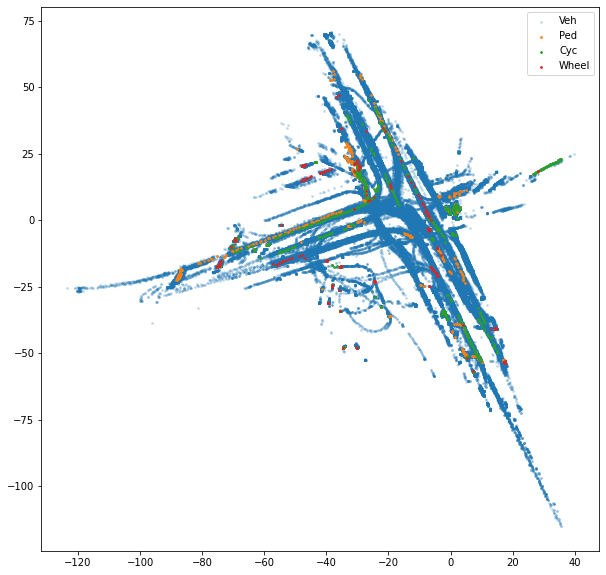

In [99]:
plt.figure(figsize=(10,10))
plt.scatter(Traj.loc[Traj.Class == 1,'Coord_X_Mea'],Traj.loc[Traj.Class == 1,'Coord_Y_Mea'], s = 3, alpha = 0.2,label = 'Veh')
plt.scatter(Traj.loc[Traj.Class == 2,'Coord_X_Mea'],Traj.loc[Traj.Class == 2,'Coord_Y_Mea'], s = 3,label = 'Ped')
plt.scatter(Traj.loc[Traj.Class == 3,'Coord_X_Mea'],Traj.loc[Traj.Class == 3,'Coord_Y_Mea'], s = 3,label = 'Cyc')
plt.scatter(Traj.loc[Traj.Class == 4,'Coord_X_Mea'],Traj.loc[Traj.Class == 4,'Coord_Y_Mea'], s = 3,label = 'Wheel')
plt.legend(fontsize = 10)
plt.show()

In [5]:
Labels = []
for t in Trajs:
    uni,cnt = np.unique(np.array(t.Class),return_counts = True)
    Labels.append(uni[np.argmax(cnt)])

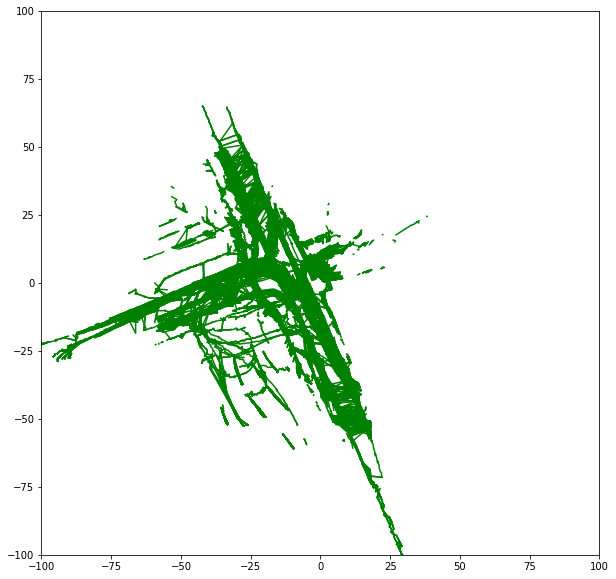

In [6]:
plt.figure(figsize=(10,10))
plt.xlim(-100,100)
plt.ylim(-100,100)
for i,t in enumerate(Trajs):
    if Labels[i] == 1:
        plt.plot(t.Coord_X_Mea,t.Coord_Y_Mea,c = 'g')
    elif Labels[i] == 2:
        plt.plot(t.Coord_X_Mea,t.Coord_Y_Mea,c = 'r')
    elif Labels[i] == 3:
        plt.plot(t.Coord_X_Mea,t.Coord_Y_Mea,c = 'y')
    else:
        plt.plot(t.Coord_X_Mea,t.Coord_Y_Mea,c = 'b')
plt.show()

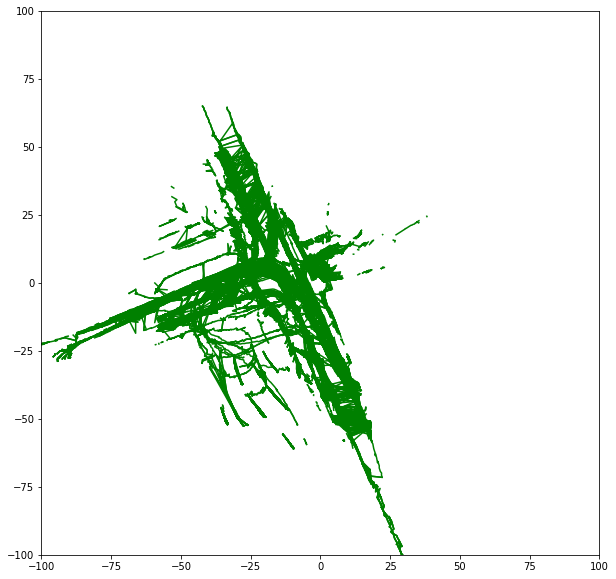

In [7]:
plt.figure(figsize=(10,10))
plt.xlim(-100,100)
plt.ylim(-100,100)
for i,t in enumerate(Trajs):
    if Labels[i] == 1:
        plt.plot(t.Coord_X_Mea,t.Coord_Y_Mea,c = 'g')
plt.show()

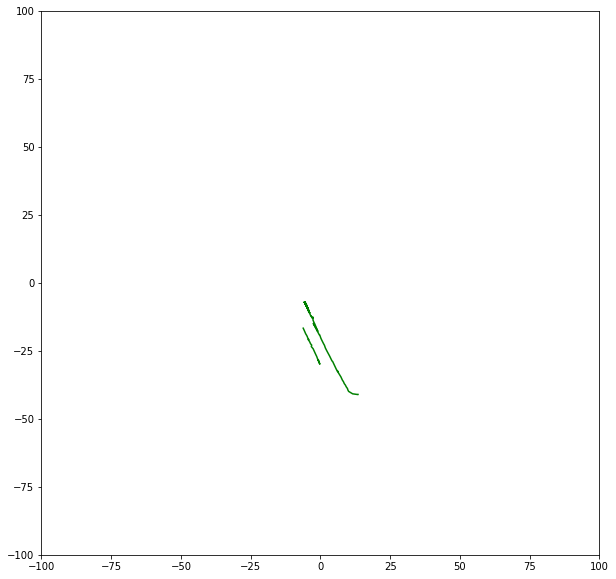

In [8]:
plt.figure(figsize=(10,10))
plt.xlim(-100,100)
plt.ylim(-100,100)
for i,t in enumerate(Trajs):
    if Labels[i] == 2:
        plt.plot(t.Coord_X_Mea,t.Coord_Y_Mea,c = 'g')
plt.show()

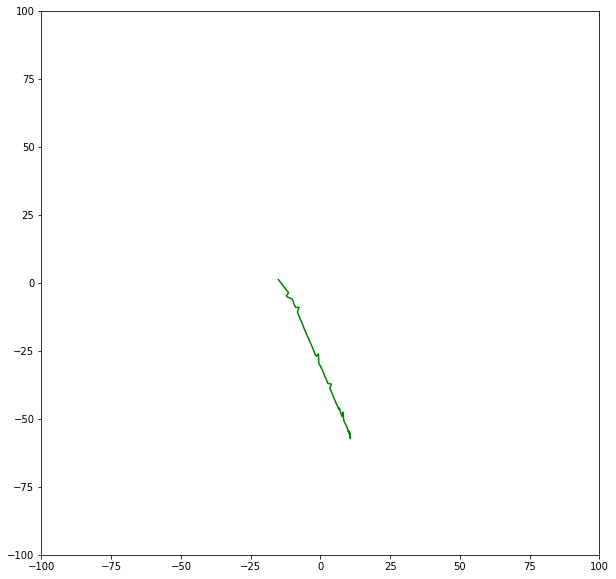

In [9]:
plt.figure(figsize=(10,10))
plt.xlim(-100,100)
plt.ylim(-100,100)
for i,t in enumerate(Trajs):
    if Labels[i] == 3:
        plt.plot(t.Coord_X_Mea,t.Coord_Y_Mea,c = 'g')
plt.show()

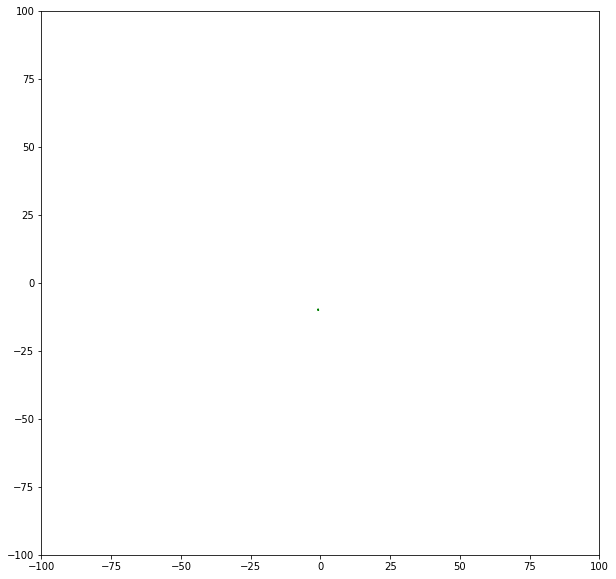

In [10]:
plt.figure(figsize=(10,10))
plt.xlim(-100,100)
plt.ylim(-100,100)
for i,t in enumerate(Trajs):
    if Labels[i] == 4:
        plt.plot(t.Coord_X_Mea,t.Coord_Y_Mea,c = 'g')
plt.show()